In [17]:
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

### Load Raw Data

Reading EGI MFF Header from /Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/mdd_dlpfc/subject6_m160_dlpfc_57/m160_dlpfc_day4/m160_dlpfc_day4_treatment_20230330_010156.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...
Reading 0 ... 613524  =      0.000 ...   613.524 secs...
Using pyopengl with version 3.1.6
Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


/Users/Bella/mambaforge/envs/klean/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Bella/mambaforge/envs/klean/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


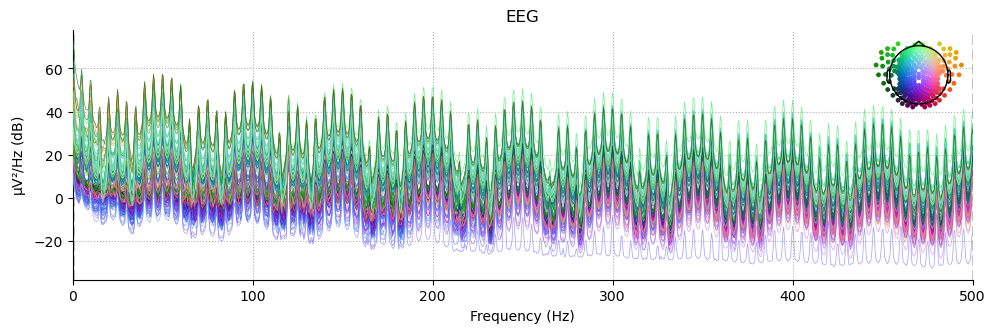

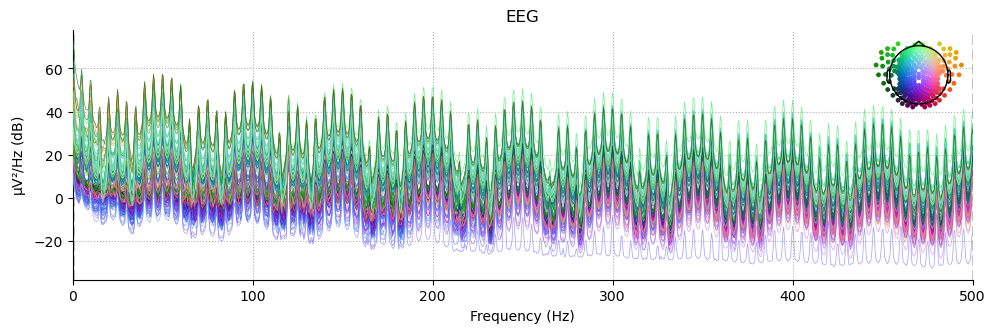

In [18]:
# Specify treatment raw file path
data_path = '/Users/Bella/Desktop/Grosenick_Lab/eeg_patient_data/mdd_dlpfc/'
data_folder = data_path+'subject6_m160_dlpfc_57/m160_dlpfc_day4/'
filename = 'm160_dlpfc_day4_treatment_20230330_010156.mff'
treatment_file_raw = os.path.join(data_folder, filename)
treatment_raw = mne.io.read_raw_egi(treatment_file_raw, preload=True)

def notch_and_hp(raw, notch_freqs, notch_widths, l_freq=1.0, h_freq=None, filter_type='fir'):
    notch_freqs = np.array(notch_freqs)
    notch_widths = np.asarray(notch_widths)
    raw_notch = raw.copy().notch_filter(freqs=notch_freqs, notch_widths=None, verbose='warning')
    raw_hp = raw_notch.filter(l_freq=l_freq, h_freq=h_freq, method=filter_type, verbose='warning')
    return raw_hp

notch_freqs = [60,120,180,240,300,360,400,420,460,480]
notch_widths = None

treatment_raw.info['bads'] = ['VREF']
treatment_filt = notch_and_hp(treatment_raw, l_freq=1.0, notch_freqs=notch_freqs, notch_widths=notch_widths)
treatment_filt = treatment_raw.filter(l_freq=0.1, h_freq=None, method='fir', verbose='warning')
treatment_filt.info['bads'] = ['VREF']

# Plot sensor traces for raw treatment data
treatment_raw.plot(n_channels=256, scalings='auto', title= f'Raw Treament EEG Data {filename}')

fig = treatment_raw.compute_psd().plot(show=True, exclude='bads') ;
sns.despine()

fig = treatment_filt.compute_psd().plot(show=True, exclude='bads') ;
sns.despine()

#treatment_filt.resample(200.0)  # resample after epoching to avoid jittering trigger timings

### Plot Spectra and Epoch data

In [19]:
# Read DIN1 events for TMS data
treatment_filt.info
treatment_events = mne.find_events(treatment_filt, stim_channel = 'DIN1')

600 events found
Event IDs: [1]


Effective window size : 2.048 (s)


/Users/Bella/mambaforge/envs/klean/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/Bella/mambaforge/envs/klean/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


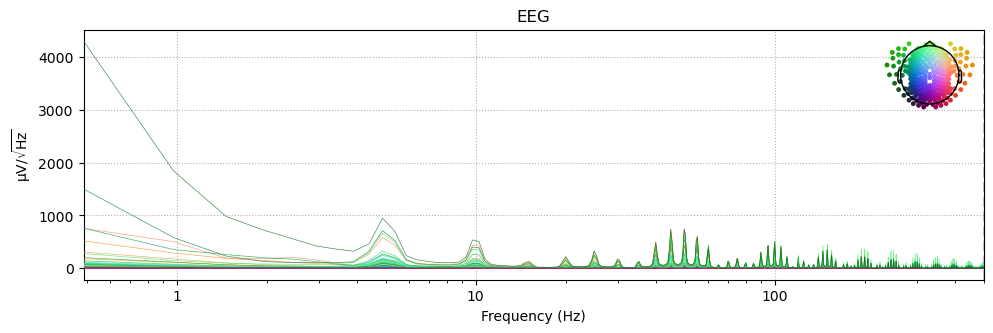

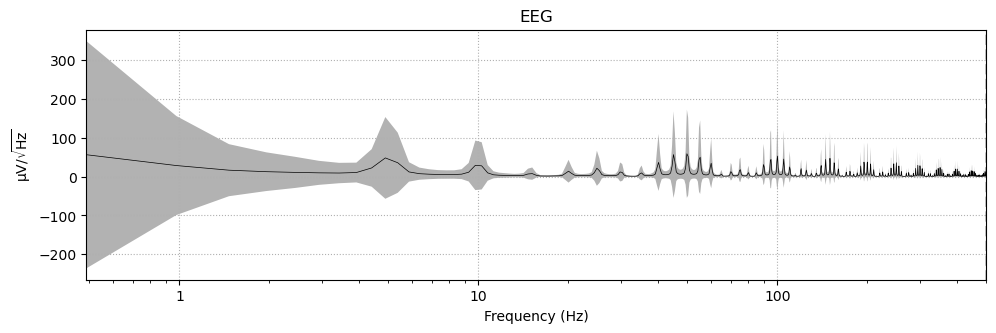

In [20]:
spectrum = treatment_filt.compute_psd()
for average in (False, True):
    spectrum.plot(average=average, dB=False, xscale="log", picks="data", exclude="bads")

### Create Epochs

In [21]:
# Create epochs for full treatment length
epochs = mne.Epochs(treatment_filt, treatment_events, tmin=-0.1, tmax=0.1, baseline=(0, 0), preload=True)
print(epochs)  # 600 epochs created for Event ID '1'

Not setting metadata
600 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 600 events and 201 original time points ...
0 bad epochs dropped
<Epochs |  600 events (all good), -0.1 – 0.1 s, baseline 0 – 0 s, ~238.6 MB, data loaded,
 '1': 600>


For epochs at target: there are 10 pulses per train, so if target is reached at train 7, epochs at target are 70
subject 9: day 1, train 14, epoch 140; day 2
subject 6: day 4, train 7, epoch 70; day 5

In [22]:
# Create epochs for portion of treatment at the target intensity
epochs_at_target = epochs[70: ]  # change this for each patient and each day according train at target
print(epochs_at_target)

<Epochs |  530 events (all good), -0.1 – 0.1 s, baseline 0 – 0 s, ~210.8 MB, data loaded,
 '1': 530>
Channels marked as bad:
['VREF']


In [6]:
#epochs.plot_image(combine="mean")

#def get_epoch_sd(epochs):
    #return np.std(epochs,axis=0)

#epochs.plot_image(combine=get_epoch_sd)

### Plot signal over epochs over time

Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated


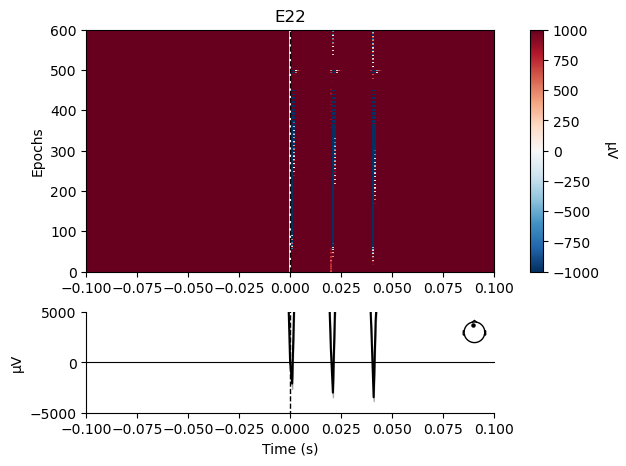

In [24]:
%matplotlib qt
# Plot epochs as an image map
fig = epochs.plot_image(picks=['E33'], vmin = -1000, vmax = 1000)
fig[0].axes[1].set_ylim([-5000, 5000])
fig[0]
fig = epochs.plot_image(picks=['E110'], vmin = -1000, vmax = 1000)
fig[0].axes[1].set_ylim([-5000, 5000])
fig[0]
fig = epochs.plot_image(picks=['E22'], vmin = -1000, vmax = 1000)
fig[0].axes[1].set_ylim([-5000, 5000])
fig[0]

Not setting metadata
530 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
530 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
530 matching events found
No baseline correction applied
0 projection items activated


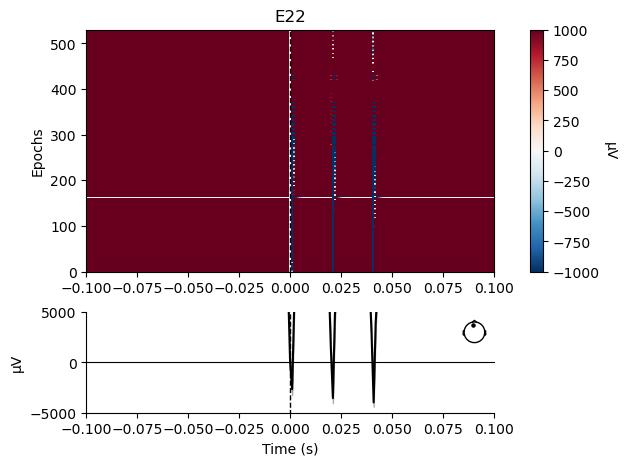

In [25]:
%matplotlib qt
# Plot epochs as an image map for epochs at target
fig = epochs_at_target.plot_image(picks=['E33'], vmin = -1000, vmax = 1000)
fig[0].axes[1].set_ylim([-5000, 5000])
fig[0]
fig = epochs_at_target.plot_image(picks=['E110'], vmin = -1000, vmax = 1000)
fig[0].axes[1].set_ylim([-5000, 5000])
fig[0]
fig = epochs_at_target.plot_image(picks=['E22'], vmin = -1000, vmax = 1000)
fig[0].axes[1].set_ylim([-5000, 5000])
fig[0]

### Topomaps

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


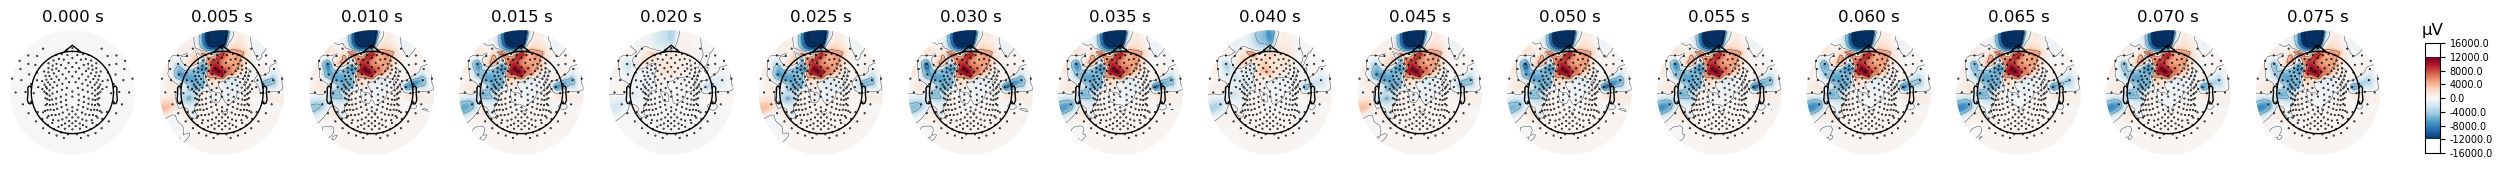

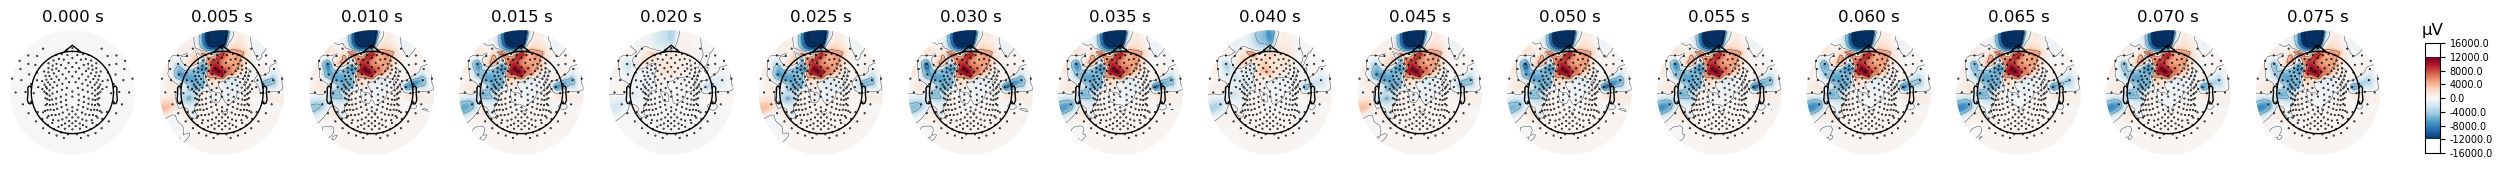

In [26]:
%matplotlib inline
evoked = epochs.average()
evoked_se = epochs.standard_error()

times = np.arange(0.0, 0.08, 0.005)
evoked.plot_topomap(times)


### Modeling the artifact with tensor decomposition (Tucker)

In [29]:
import tensorly as tl
from tensorly.decomposition import tucker, parafac

#epoch_data = epochs.get_data()[:,0:257,:]
#epoch_stim = epochs.get_data()[:,257:,:]
epoch_data = epochs_at_target.get_data()[:,0:257,:]
epoch_stim = epochs_at_target.get_data()[:,257:,:]

import time
tic = time.time()
tucker_decomp = tucker(epoch_data,60)  # What is 60?
#cp_decomp = parafac(epoch_data,60)
print(time.time()-tic)

/Users/Bella/mambaforge/envs/klean/lib/python3.11/site-packages/tensorly/tucker_tensor.py:425: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


16.026108980178833


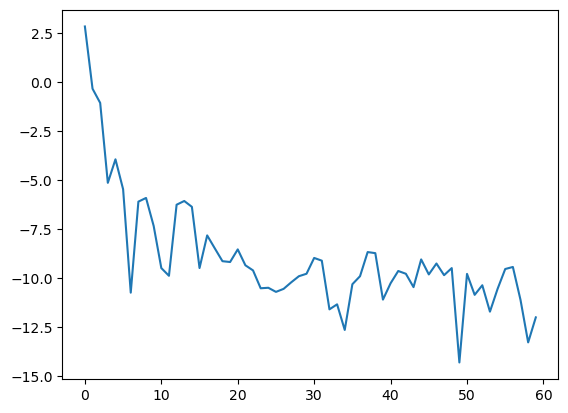

In [30]:
%matplotlib inline
# Plot tensor equivalent of singular values (diagonal of core tensor)
def get_3dtensor_diag(tensor):
    diag = []
    for i in range(tensor.shape[0]):
        diag.append(tensor[i,i,i])
    return np.array(diag)
tucker_diag = get_3dtensor_diag(tucker_decomp.core)
plt.plot(np.log(np.abs(tucker_diag)))

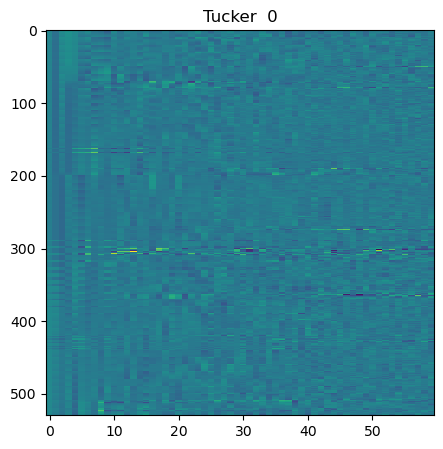

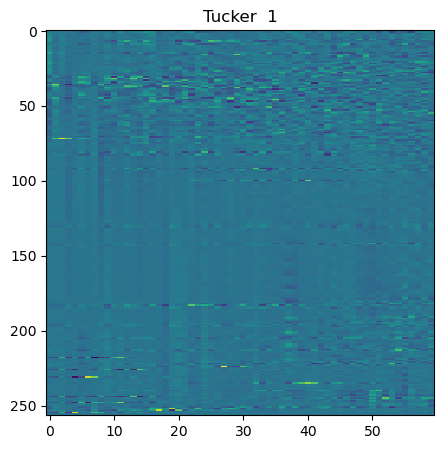

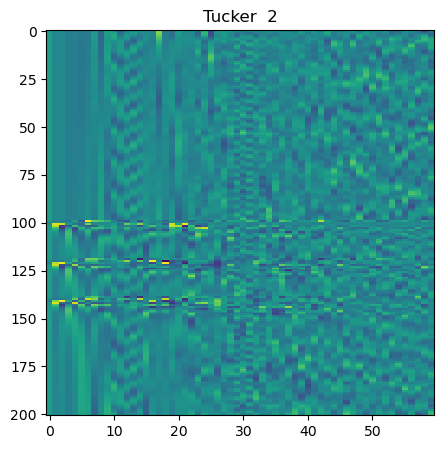

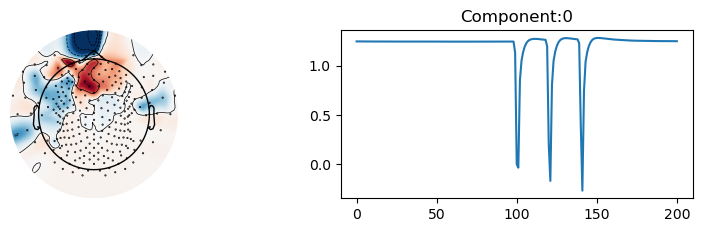

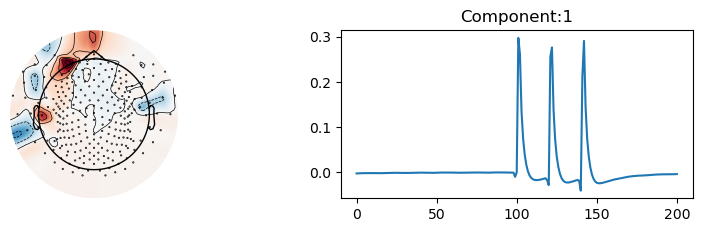

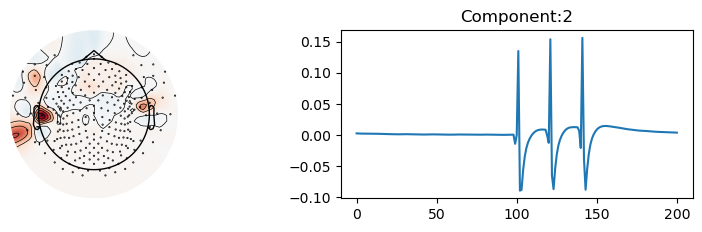

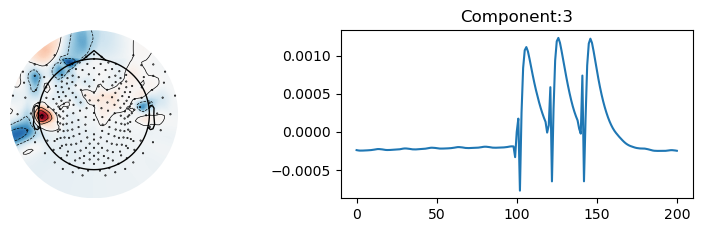

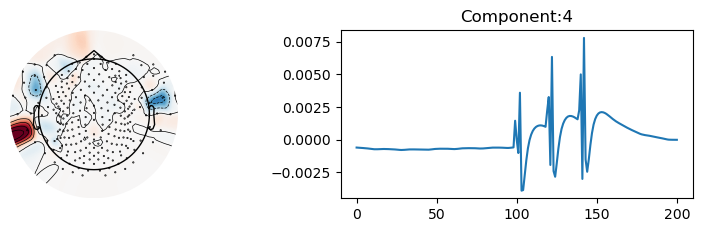

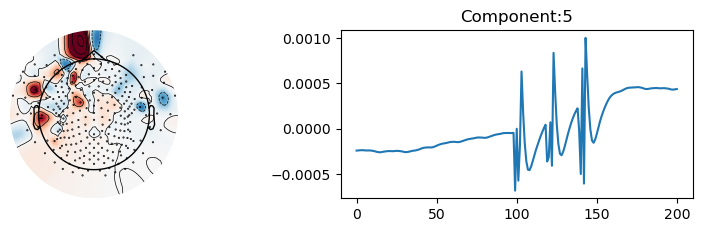

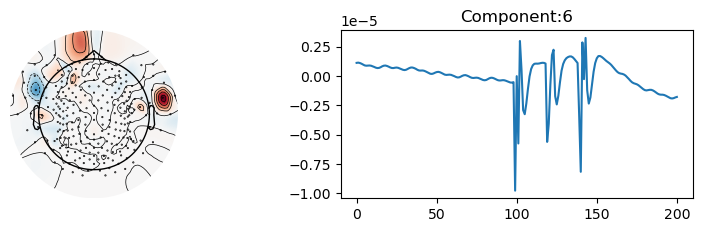

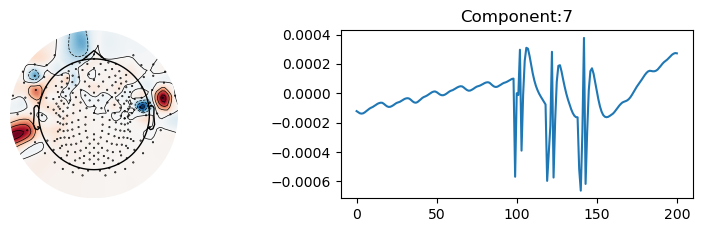

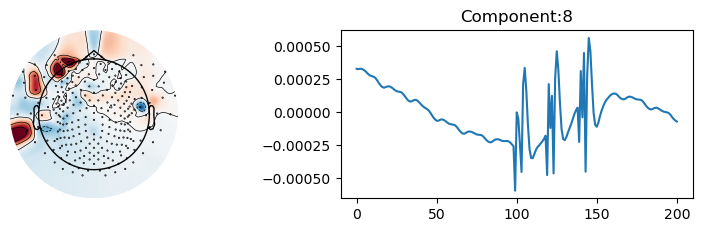

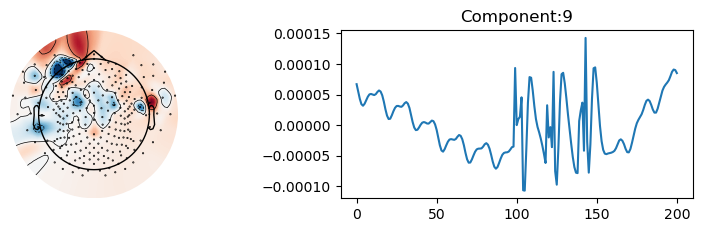

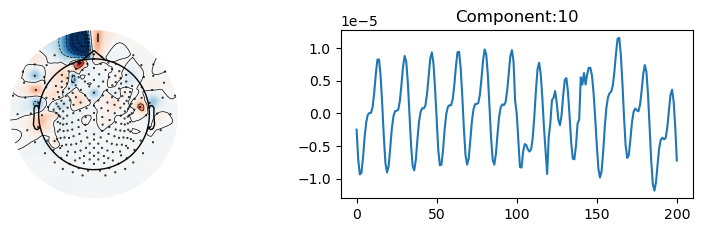

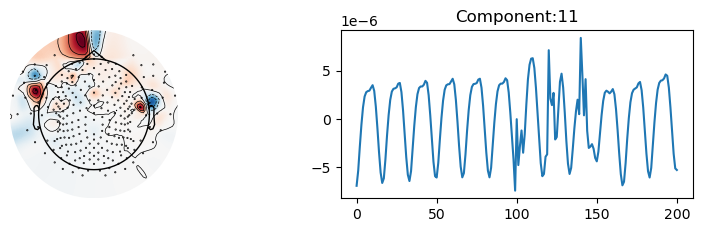

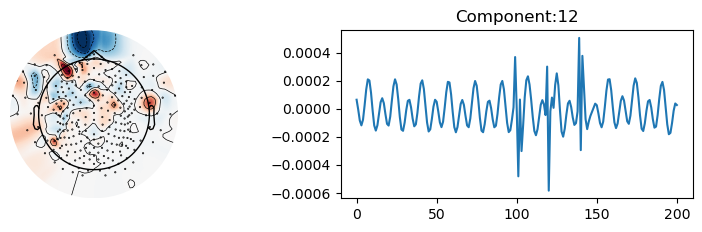

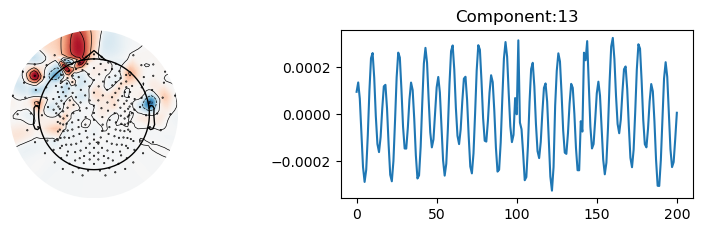

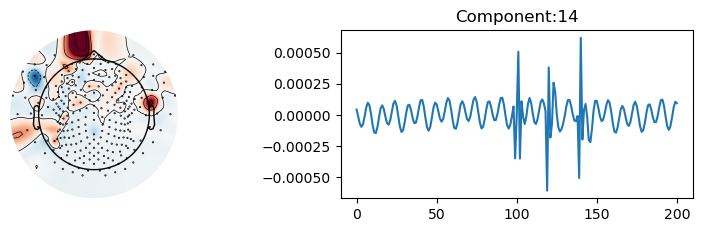

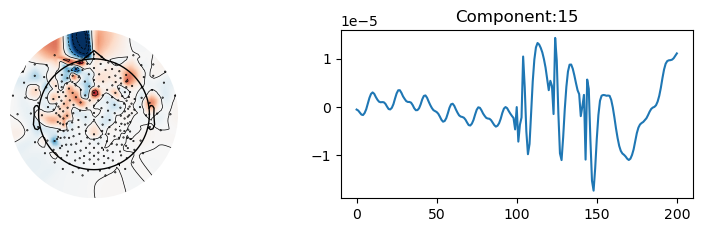

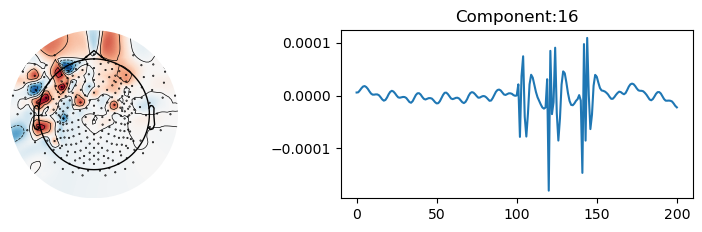

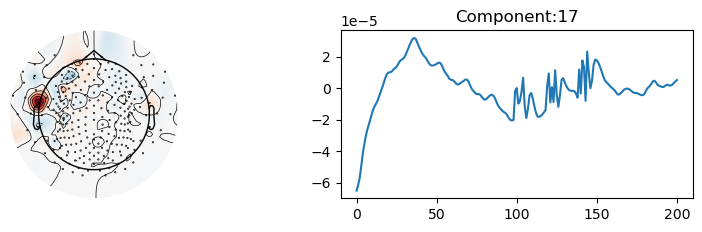

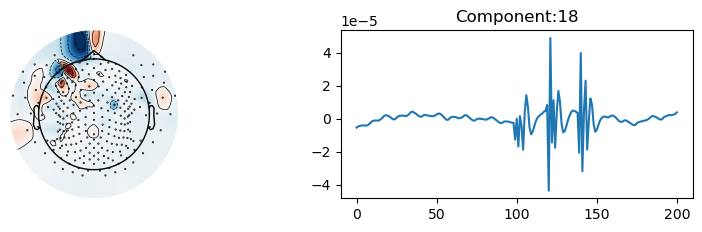

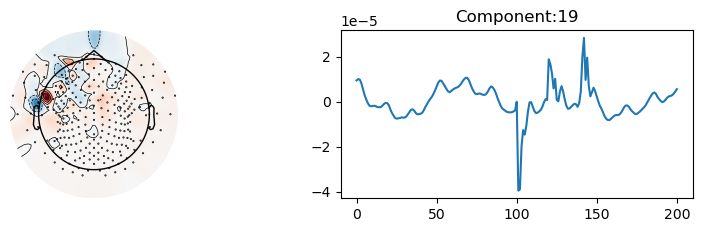

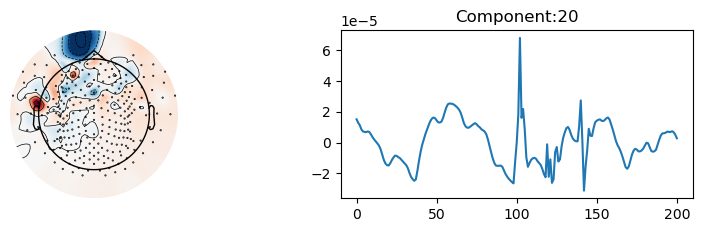

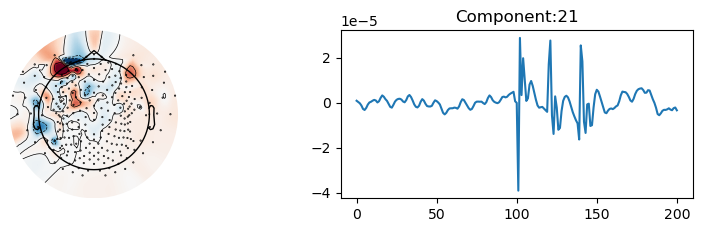

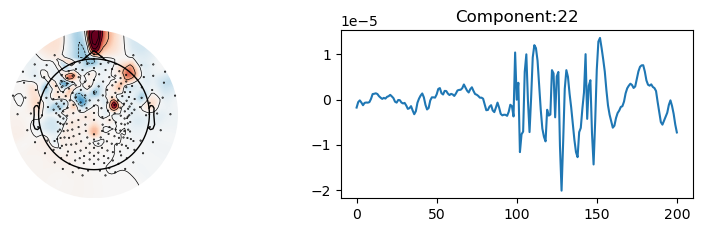

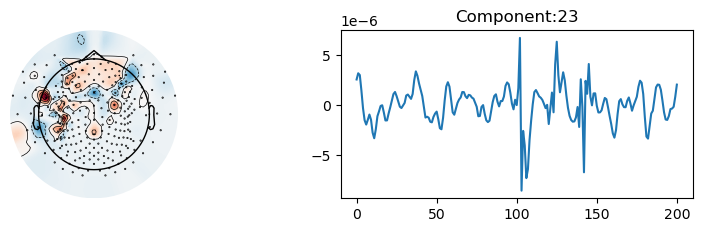

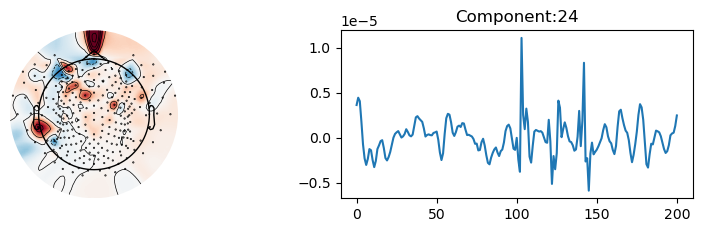

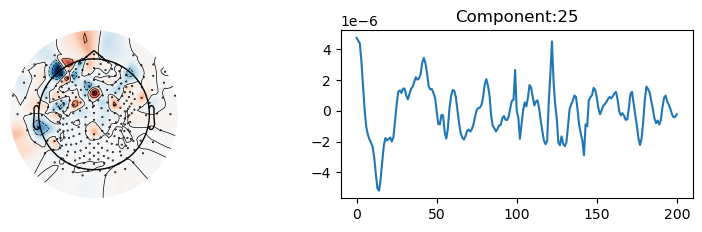

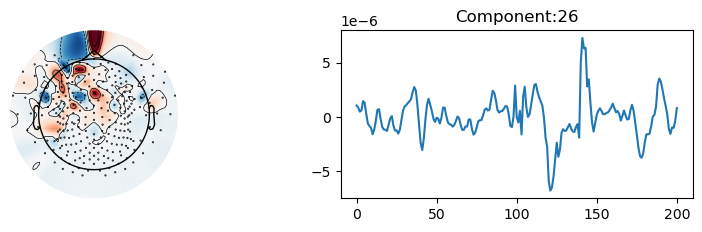

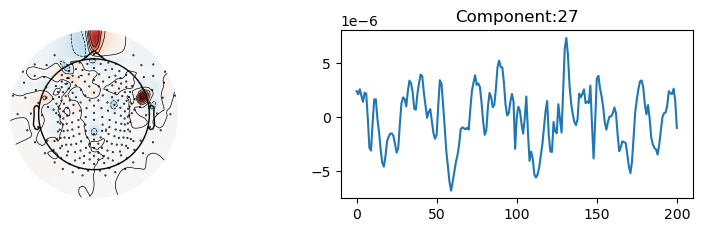

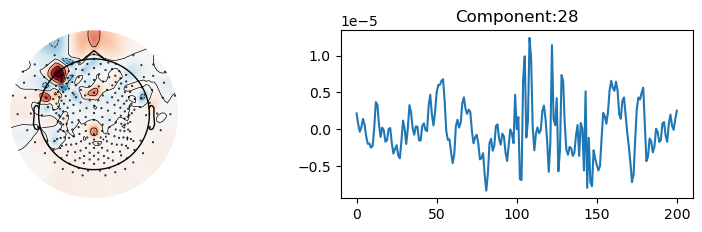

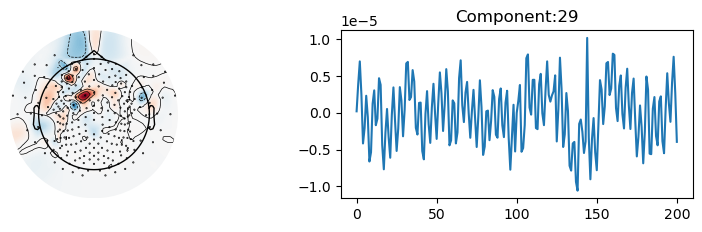

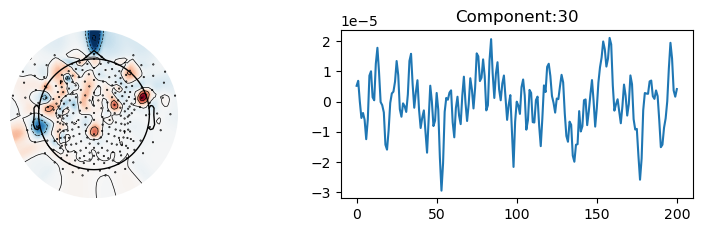

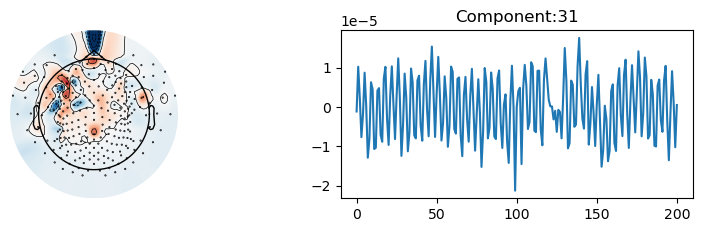

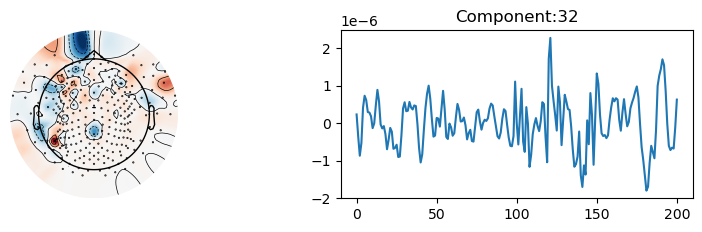

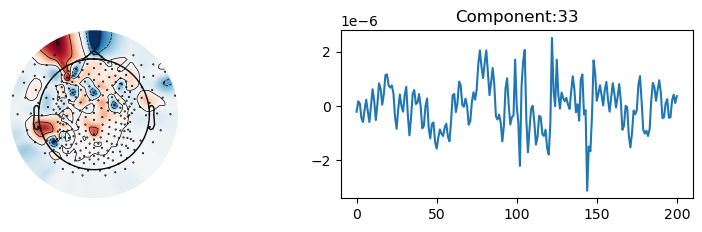

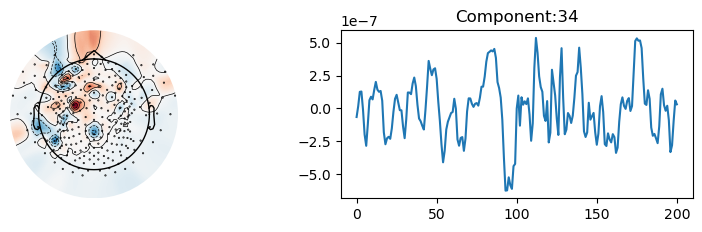

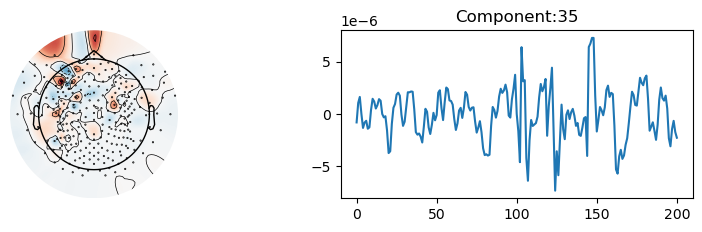

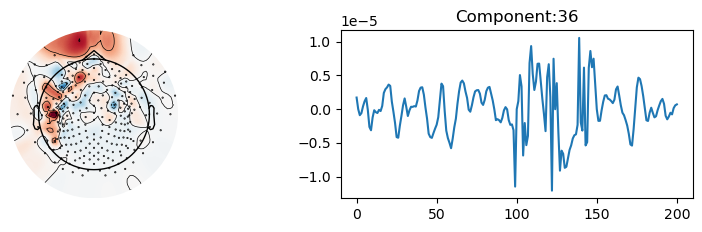

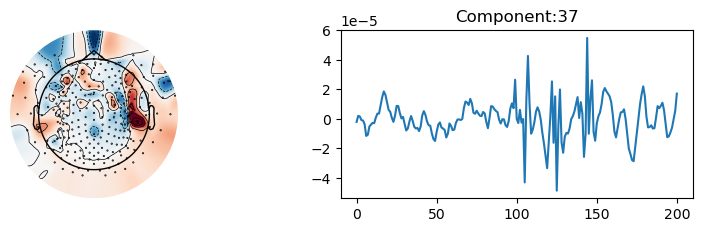

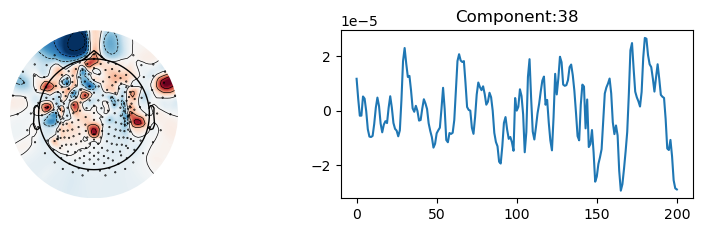

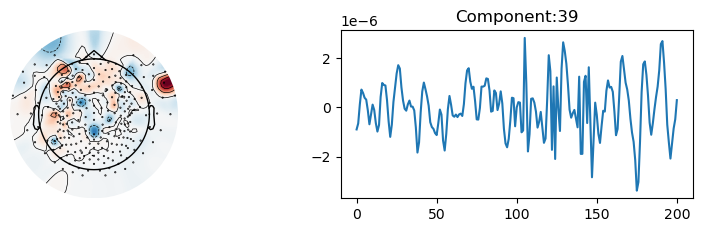

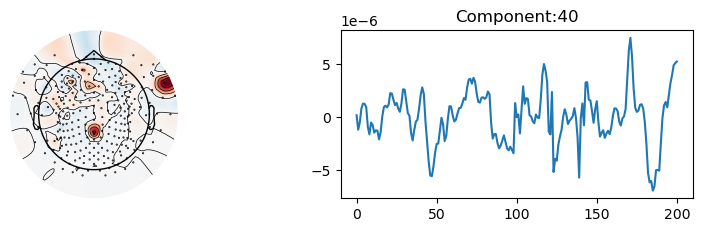

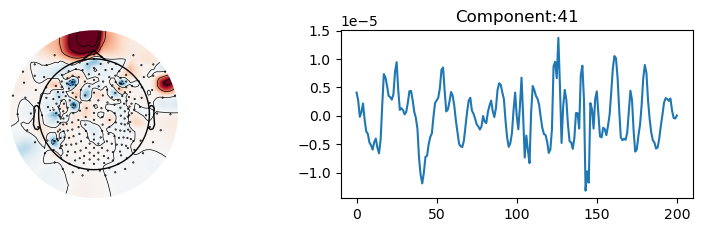

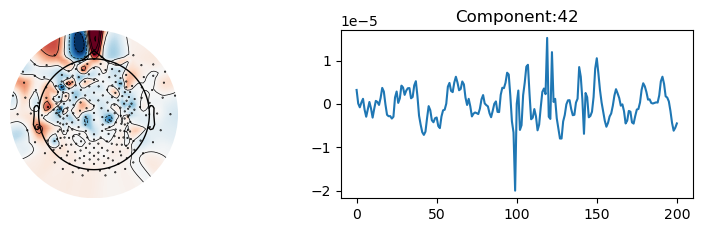

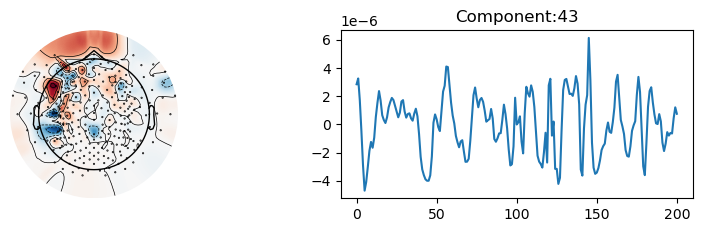

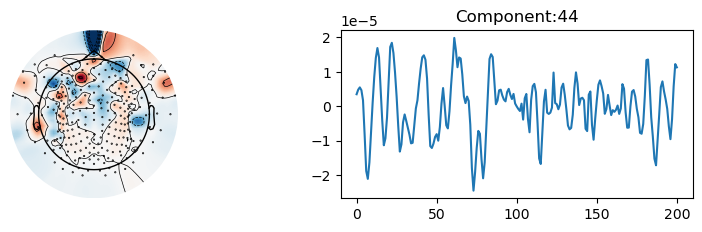

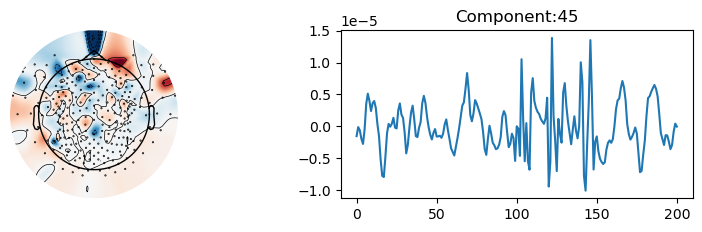

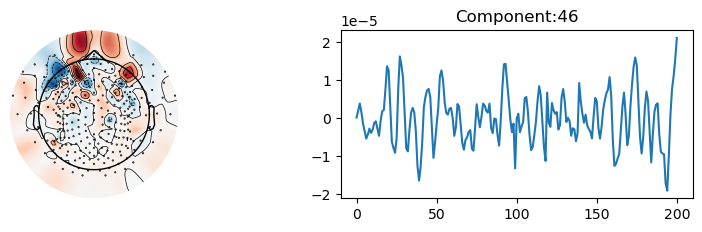

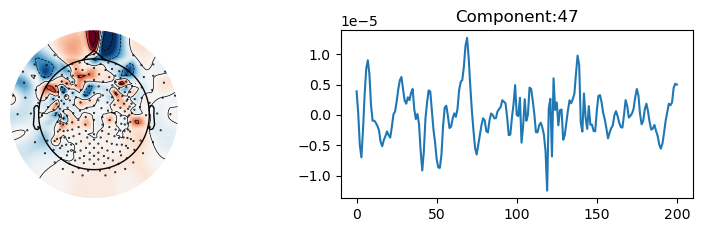

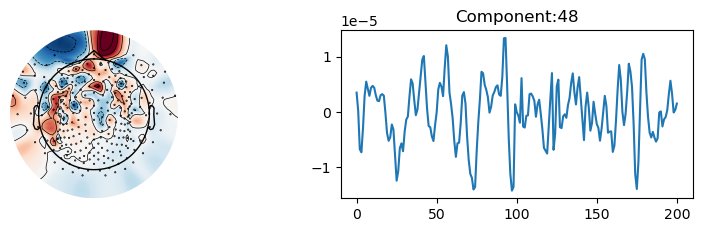

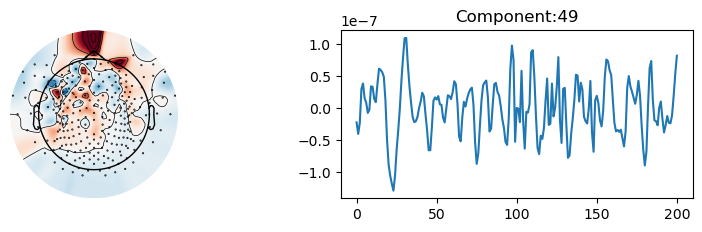

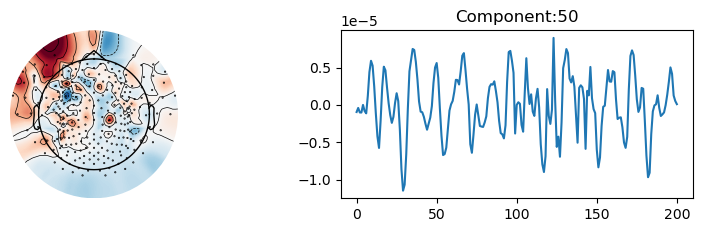

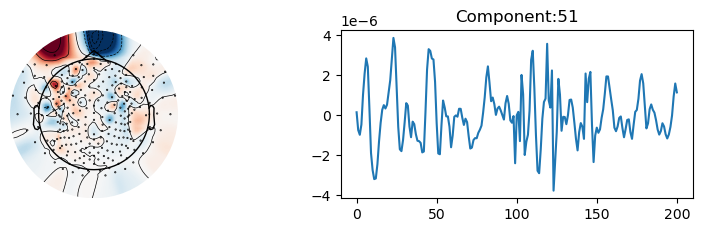

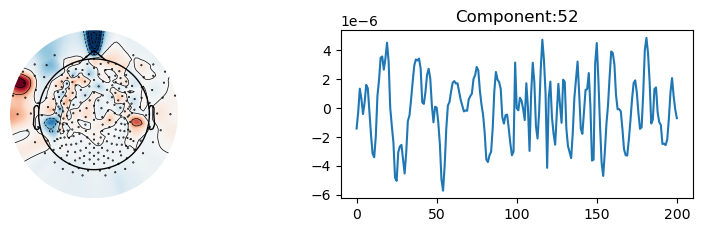

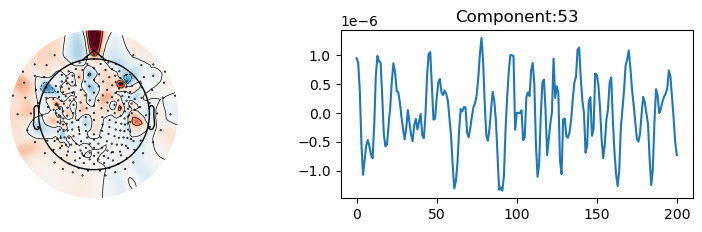

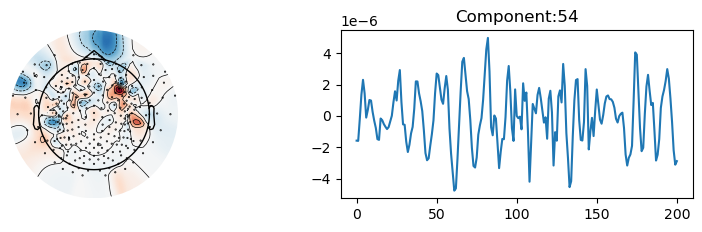

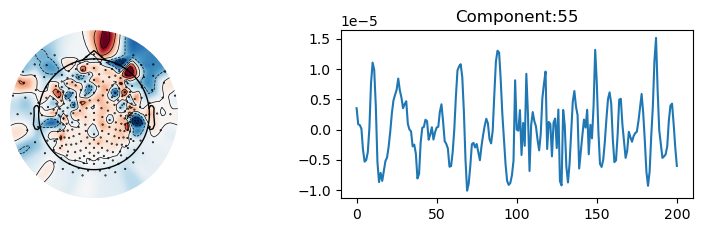

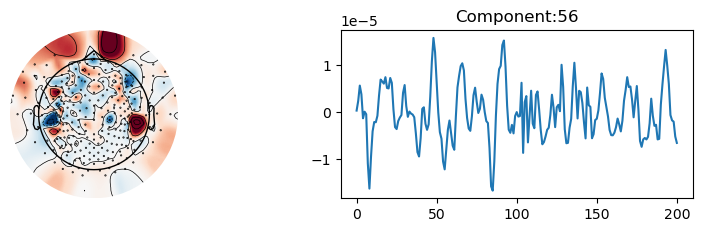

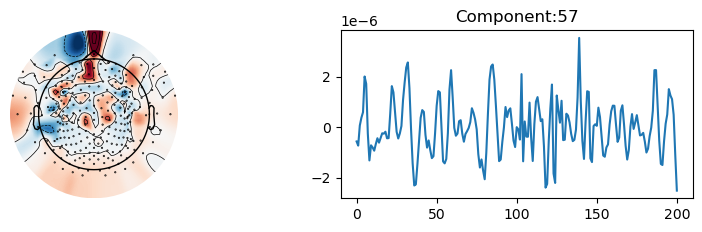

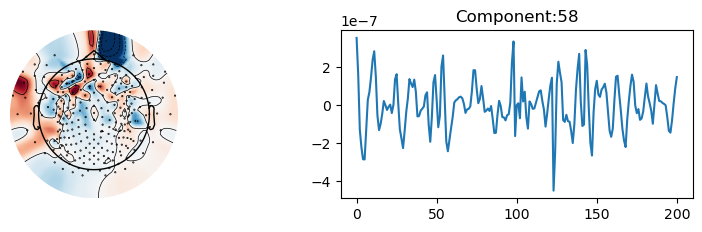

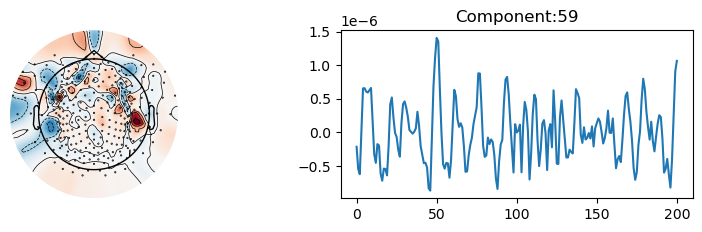

In [31]:
%matplotlib inline
# for i in range(3):
#     plt.figure(figsize=(5,5))
#     plt.imshow(cp_decomp.factors[i],aspect='auto',interpolation='nearest')
#     plt.title("CP "+str(i))

# Plot images of 2D factors
for i in range(3):
    plt.figure(figsize=(5,5))
    plt.imshow(tucker_decomp.factors[i],aspect='auto',interpolation='nearest')
    plt.title("Tucker  "+str(i))

# Plot scalp maps and time series corresponding to tensor decomposition components
for i in range(60):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,2))
    ax2.plot(tucker_diag[i]*tucker_decomp.factors[2][:,i])
    ax2.set_title("Component:"+str(i))
    mne.viz.plot_topomap(tucker_decomp.factors[1][:,i], pos=treatment_raw.info, axes=ax1)

In [39]:
# Zero out first n components to try and remove artifact
tucker_decomp.factors[2][:,0:38] = 0.0


Not setting metadata
530 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
530 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
530 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
530 matching events found
No baseline correction applied
0 projection items activated


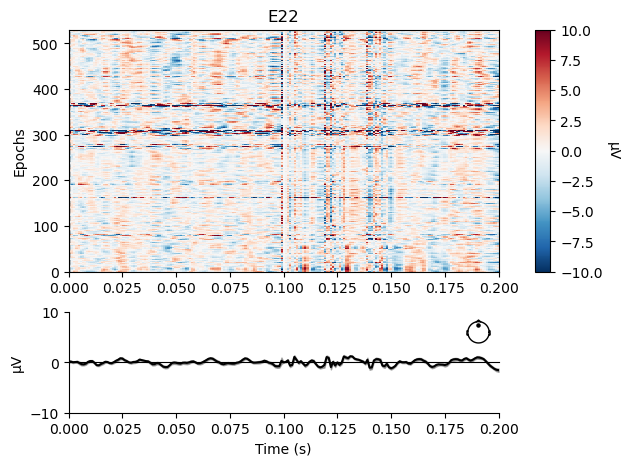

In [41]:
%matplotlib qt
# Plot channel over epochs pre artifact removal
#epochs.plot_image(picks=['E110'], vmin=-2500, vmax=2500)
#epochs.plot_image(picks=['E33'], vmin=-2500, vmax=2500)

# Plot channel over epochs post artifact removal
tensor_cleaned = tl.tucker_to_tensor(tucker_decomp)
tensor_cleaned = np.concatenate((tensor_cleaned,epoch_stim),axis=1)
epochs_cleaned = mne.EpochsArray(tensor_cleaned,epochs.info)

fig = epochs_cleaned.plot_image(picks=['E33'], vmin= -10, vmax= 10)
fig[0].axes[1].set_ylim([-10,10])
fig[0]
fig = epochs_cleaned.plot_image(picks=['E110'], vmin= -10, vmax= 10)
fig[0].axes[1].set_ylim([-10,10])
fig[0]
fig = epochs_cleaned.plot_image(picks=['E22'], vmin= -10, vmax= 10)
fig[0].axes[1].set_ylim([-10,10])
fig[0]


#epochs_cleaned.plot_image(picks=['E33'], vmin=-10, vmax=10, axes={1:[0, 0.2, 0, 600], evoked:[-0.25, 0.25], 3:[-10, 10]})

### Artifact removal with CEBRA

In [42]:
from cebra import CEBRA

cebra_time_model = CEBRA(model_architecture='offset10-model',
                        batch_size=1024,
                        learning_rate=3e-4,
                        temperature=1.0,
                        output_dimension=250,
                        max_iterations=10000,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=500)
cebra_time_model.fit(treatment_raw.get_data().T)
#cebra_time_model.save("cebra_time_model.pt")

pos: -0.9279 neg:  7.0799 total:  6.1519 temperature:  1.0000: 100%|█| 10000/10000 [05:27<00


CEBRA(batch_size=1024, conditional='time', model_architecture='offset10-model',
      output_dimension=250, time_offsets=500, verbose=True)

In [43]:
import cebra
ax1 = plt.subplot(111, projection='3d')
cebra_time = cebra_time_model.transform(treatment_raw.get_data().T)
cebra.plot_embedding(ax=ax1, embedding=cebra_time, title='CEBRA-Time') #, cmap=cmap)


<Axes3D: title={'center': 'CEBRA-Time'}>

In [44]:
plt.figure(figsize=(10,2))
for component_num in range(0,250,80):
    plt.figure(figsize=(10,2))
    plt.plot(cebra_time[105000:105500,component_num])
    plt.title("CEBRA Component: "+str(component_num))
    plt.xlabel("Time Samples (1000 Hz)")
    plt.ylabel("A.U.")
    sns.despine()


### Modeling the artifact with ICA

In [45]:
from sklearn.decomposition import FastICA
import scipy
import pywt
def wICA(ica, ICs, levels=7, wavelet='coif5', normalize=False, 
         trim_approx=False, thresholding='soft', verbose=True):
    '''
    Wavelet ICA thresholding. 
    Args:
        ica: fitted ica object (currently only works with Sklearn's FastICA). TODO: add MNE options.
        ICs: a numpy array of independent components with shape: (#time points, #components).
        levels: number of wavelet levels.
        wavelet: wavelet to use, defaults to Coiflet 5.
        normalize: boolean, see pywt.swt documentation
        trim_approx: boolean, see pywt.swt documentation
        thresholding: 'hard' or 'soft',  should wavelet thresholding use a hard or soft threshold.
        verbose: boolean flag for verbose printing.
    Returns:
        wICs: the wavelet thresholded ICs, leaving only large amplitude effects.
        artifacts: the wICs ICA inverse transformed back to ambient data space, shape: (#time points, #channels). 
    '''
    # Pad out the data to the correct length for wavelet thresholding
    modulus = np.mod(ICs.shape[0],2**levels)
    if modulus !=0:
        extra = np.zeros((2**levels)-modulus)
    if verbose:
        print('  Data padded with ', str(len(extra)), ' additional values.')
        print('  Wavelet thresholding with wavelet:', wavelet)
    wavelet = pywt.Wavelet(wavelet)

    # Iterate over independent components, thresholding each one using a stationary wavelet transform
    # with soft thresholding. 
    print('  Fitting ICA for wavelet-ICA cleaning...')
    wICs = []
    for i in range(ICs.shape[1]):
        if verbose:
            print("  Thresholding IC#",i)
        sig = np.concatenate((ICs[:,i],extra))
        thresh = ddencmp(sig, wavelet)
        swc = pywt.swt(sig, wavelet, level=levels, start_level=0, trim_approx=trim_approx, norm=normalize)
        y = pywt.threshold(swc, thresh, mode=thresholding, substitute=0)
        wICs.append(pywt.iswt(y, wavelet, norm=normalize))
    wICs = np.asarray(wICs)[:,0:ICs.shape[0]].T
    
    print("  Computing cleaned inverse transform...")
    artifacts = ica.inverse_transform(ICs)

    #artifacts = np.dot(ICs, ica.mixing_.T)

    #mean_tol = 1e-6
    #if ica.whiten:
    #    for i, mean in enumerate(ica.mean_):
    #        print("  adding back mean ", str(i))
    #        if np.abs(mean) > mean_tol:
    #            artifacts[:,i] = artifacts[:,i] + mean

    return wICs, artifacts

def ddencmp(x, wavelet='db1', scale=2.0):
    '''
    Python recreation of MATLAB's ddencmp function for choosing wavelet threshold using 
    Donoho and Johnstone universal threshold scaled by a robust variance estimate.
    Arg 'scale' allows adjusting the threshold more manually.

    '''
    n = len(x)
    (cA, cD)  = pywt.dwt(x,wavelet)
    noiselev = np.median(np.abs(cD))/0.6745
    thresh = np.sqrt(2*np.log(len(x)))*noiselev*scale
    return thresh

In [46]:
# Run wICA
# Try applying to filtered data. Removing slow drifts prior to wICA may improve the fit
ica = FastICA(n_components=250, whiten="arbitrary-variance")
ica.fit(treatment_raw.get_data(start=140).T)  # What is .T?
ICs = ica.fit_transform(epochs_at_target)  # Why apply wICA to raw instead of filtered data?
wICs, artifacts = wICA(ica, ICs)

ValueError: Found array with dim 3. FastICA expected <= 2.

In [ ]:
cleaned = treatment_filt.get_data(start=140) - artifacts.T
cleaned.min(), cleaned.max()

In [ ]:
cleaned = treatment_filt.get_data(start=140) - artifacts.T

# Plot imagemap for pre-wICA
wICA_artifact_raw = mne.io.RawArray(artifacts.T,treatment_filt.info)
new_events = mne.find_events(wICA_artifact_raw, stim_channel = 'DIN1')
wICA_artifact_epochs = mne.Epochs(wICA_artifact_raw, new_events, tmin=-0.1, tmax=0.1, baseline=(0, 0))
fig = wICA_artifact_epochs.plot_image(picks=['E110'], vmin=-10000, vmax=10000)
fig[0].axes[1].set_ylim([-10000,10000])
fig[0]

In [ ]:
# Plot imagemap for post-wICA

# how to 
%matplotlib qt
wICA_cleaned = mne.io.RawArray(cleaned, treatment_filt.info)
new_events_cleaned = mne.find_events(wICA_cleaned, stim_channel = 'DIN1')
wICA_cleaned_epochs = mne.Epochs(wICA_cleaned, new_events_cleaned, tmin=-0.1, tmax=0.1, baseline=(0, 0))

#fig = wICA_cleaned_epochs.plot_image(picks=['E110'])
#fig[0].axes[1].set_ylim([-10,10])
#fig[0]

In [ ]:
plt.figure(figsize=(10,2))
for component_num in range(0,250,80):
    plt.figure(figsize=(10,2))
    plt.plot(ICs[105000:105500,component_num])
    plt.title("ICA Component: "+str(component_num))
    plt.xlabel("Time Samples (1000 Hz)")
    plt.ylabel("A.U.")
    sns.despine()
